# 2022-10-28 Finite Elements

## Last time

* Galerkin for Poisson
* Finite element constructions

## Today

* libCEED abstraction
* Restriction to elements
* Nonlinear problems and the QFunction abstraction
* Advection-diffusion

In [1]:
using Plots
default(linewidth=3)
using LinearAlgebra
using SparseArrays
using FastGaussQuadrature

function my_spy(A)
    cmax = norm(vec(A), Inf)
    s = max(1, ceil(120 / size(A, 1)))
    spy(A, marker=(:square, s), c=:diverging_rainbow_bgymr_45_85_c67_n256, clims=(-cmax, cmax))
end

function vander_legendre_deriv(x, k=nothing)
    if isnothing(k)
        k = length(x) # Square by default
    end
    m = length(x)
    Q = ones(m, k)
    dQ = zeros(m, k)
    Q[:, 2] = x
    dQ[:, 2] .= 1
    for n in 1:k-2
        Q[:, n+2] = ((2*n + 1) * x .* Q[:, n+1] - n * Q[:, n]) / (n + 1)
        dQ[:, n+2] = (2*n + 1) * Q[:,n+1] + dQ[:,n]
    end
    Q, dQ
end

function febasis(P, Q)
    x, _ = gausslobatto(P)
    q, w = gausslegendre(Q)
    Pk, _ = vander_legendre_deriv(x)
    Bp, Dp = vander_legendre_deriv(q, P)
    B = Bp / Pk
    D = Dp / Pk
    x, q, w, B, D
end

function L2_galerkin(P, Q, f)
    x, q, w, B, _ = febasis(P, Q)
    A = B' * diagm(w) * B
    rhs = B' * diagm(w) * f.(q)
    u = A \ rhs
    x, u
end

L2_galerkin (generic function with 1 method)

![](../img/libCEED-2-trim.svg)

# General form
$$ \int_\Omega v\cdot f_0(u, \nabla u) + \nabla v\cdot f_1(u, \nabla u) = 0, \quad \forall v$$
we discretize as
$$ \sum_e \mathcal E_e^T \Big( B^T W \left\lvert \frac{\partial x}{\partial X} \right\rvert f_0(\tilde u, \nabla \tilde u) + D^T \left(\frac{\partial X}{\partial x}\right)^{T} W \left\lvert \frac{\partial x}{\partial X} \right\rvert f_1(\tilde u, \nabla\tilde u) \Big) = 0 $$
where $\tilde u = B \mathcal E_e u$ and $\nabla \tilde u = \frac{\partial X}{\partial x} D \mathcal E_e u$ are the values and gradients evaluated at quadrature points.

## Isoparametric mapping

Given the reference coordinates $X \in \hat K \subset R^n$ and physical coordinates $x(X)$, an integral on the physical element can be written
$$ \int_{K = x(\hat K)} f(x) dx = \int_K \underbrace{\left\lvert \frac{\partial x}{\partial X} \right\rvert}_{\text{determinant}} f(x(X)) dX .$$

| Notation | Meaning |
|---------|:-------------|
| $x$ | physical coordinates |
| $X$ | reference coordinates |
| $\mathcal E_e$ | restriction from global vector to element $e$ |
| $B$ | values of nodal basis functions at quadrature ponits on reference element |
| $D$ | gradients of nodal basis functions at quadrature points on reference element|
| $W$ | diagonal matrix of quadrature weights on reference element |
| $\frac{\partial x}{\partial X} = D \mathcal E_e x $ | gradient of physical coordinates with respect to reference coordinates |
| $\left\lvert \frac{\partial x}{\partial X}\right\rvert$ | determinant of coordinate transformation at each quadrature point |
| $\frac{\partial X}{\partial x} = \left(\frac{\partial x}{\partial X}\right)^{-1}$ | derivative of reference coordinates with respect to physical coordinates |

# Finite element mesh and restriction

In [104]:
function fe1_mesh(P, nelem)
    x = LinRange(-1, 1, nelem+1)
    rows = Int[]
    cols = Int[]
    for i in 1:nelem
        append!(rows, (i-1)*P+1:i*P)
        append!(cols, (i-1)*(P-1)+1:i*(P-1)+1)
    end
    x, sparse(cols, rows, ones(nelem*P))'
end
P, nelem = 4, 3
x, E = fe1_mesh(P, nelem)
E

12×10 Adjoint{Float64, SparseMatrixCSC{Float64, Int64}} with 12 stored entries:
 1.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅   1.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅   1.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅   1.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅   1.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅   1.0   ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅   1.0   ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   1.0   ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   1.0   ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   1.0   ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   1.0   ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   1.0

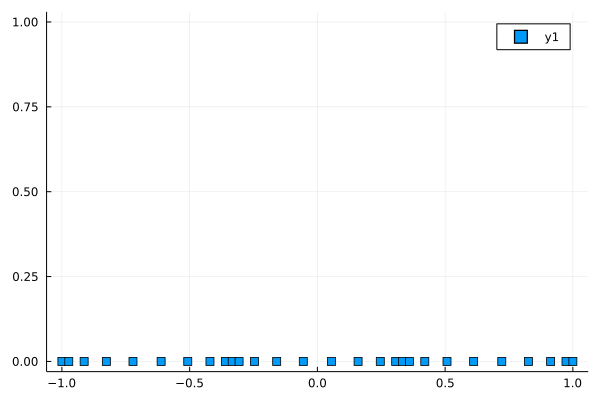

In [105]:
function xnodal(x, P)
    xn = Float64[]
    xref, _ = gausslobatto(P)
    for i in 1:length(x)-1
        xL, xR = x[i:i+1]
        append!(xn, (xL+xR)/2 .+ (xR-xL)/2 * xref[1+(i>1):end])
    end
    xn
end
xn = xnodal(x, 10)
scatter(xn, zero, marker=:square)

# Finite element building blocks

In [40]:
struct FESpace
    P::Int
    Q::Int
    nelem::Int
    x::Vector
    xn::Vector
    Et::SparseMatrixCSC{Float64, Int64}
    q::Vector
    w::Vector
    B::Matrix
    D::Matrix
    function FESpace(P, Q, nelem)
        x, E = fe1_mesh(P, nelem)
        xn = xnodal(x, P)
        _, q, w, B, D = febasis(P, Q)
        new(P, Q, nelem, x, xn, E', q, w, B, D)
    end
end

In [106]:
# Extract out what we need for element e
function fe_element(fe, e)
    xL, xR = fe.x[e:e+1]
    q = (xL+xR)/2 .+ (xR-xL)/2*fe.q
    w = (xR - xL)/2 * fe.w
    E = fe.Et[:, (e-1)*fe.P+1:e*fe.P]'
    dXdx = ones(fe.Q) * 2 / (xR - xL)
    q, w, E, dXdx
end

fe = FESpace(3, 3, 5)
q, w, E, dXdx = fe_element(fe, 1);
@show q
@show sum(w)
E

q = [-0.9549193338482966, -0.8, -0.6450806661517035]
sum(w) = 0.3999999999999999


3×11 Adjoint{Float64, SparseMatrixCSC{Float64, Int64}} with 3 stored entries:
 1.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅   1.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅   1.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 

# Finite element residual assembly
$$ v^T F(u) \sim \int_\Omega v\cdot f_0(u, \nabla u) + \nabla v\cdot f_1(u, \nabla u) = 0, \quad \forall v$$
$$ \sum_e \mathcal E_e^T \Big( B^T W \left\lvert \frac{\partial x}{\partial X} \right\rvert f_0(\tilde u, \nabla \tilde u) + D^T \left(\frac{\partial X}{\partial x}\right)^{T} W \left\lvert \frac{\partial x}{\partial X} \right\rvert f_1(\tilde u, \nabla\tilde u) \Big) = 0 $$
where $\tilde u = B \mathcal E_e u$ and $\nabla \tilde u = \frac{\partial X}{\partial x} D \mathcal E_e u$ are the values and gradients evaluated at quadrature points.

In [122]:
kappa(x) = 0.6 .+ 0.4*sin(pi*x/2)
fq(q, u, Du) = 0*u .- 1, kappa.(q) .* Du
dfq(q, u, du, Du, Ddu) = 0*du, kappa.(q) .* Ddu

function fe_residual(u_in, fe, fq; bci=[1], bcv=[1.])
    u = copy(u_in); v = zero(u)
    u[bci] = bcv
    for e in 1:fe.nelem
        q, w, E, dXdx = fe_element(fe, e)
        B, D = fe.B, fe.D
        ue = E * u
        uq = B * ue
        Duq = dXdx .* (D * ue)
        f0, f1 = fq(q, uq, Duq)
        ve = B' * (w .* f0) + D' * (dXdx .* w .* f1)
        v += E' * ve
    end
    v[bci] = u_in[bci] - u[bci]
    #println("residual")
    v
end

fe_residual (generic function with 1 method)

In [113]:
import NLsolve: nlsolve

fe = FESpace(3, 3, 20)
u0 = zero(fe.xn)
sol = nlsolve(u -> fe_residual(u, fe, fq), u0; method=:newton)
#plot(fe.xn, sol.zero, marker=:auto)

residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
residual
r

Results of Nonlinear Solver Algorithm
 * Algorithm: Newton with line-search
 * Starting Point: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 * Zero: [1.0000000000039475, 1.4927406210509597, 1.9672049360599393, 2.4184464161953563, 2.842731803751349, 3.237606533113795, 3.601932148325619, 3.935620553694385, 4.239530313788561, 4.515069053115947, 4.764128759073442, 4.988727193305379, 5.1910305785624775, 5.373093946001602, 5.536940081173518, 5.684391333646472, 5.81716450203112, 5.936767982438539, 6.044588540803668, 6.141830397098076, 6.229584974973035, 6.308795718312478, 6.3803102227209045, 6.444860602250416, 6.503100675080583, 6.555595710653866, 6.602848027373359, 6.645292412165557, 6.683313141956646, 6.71724283409507, 6.747373276818846, 6.773956336883946, 6.797210378615518, 6.817322369848602, 6.834451177061841, 6.848730316022175, 6

# Finite element Jacobian assembly

$$ v^T F(u) \sim \int_\Omega v\cdot f_0(u, \nabla u) + \nabla v\cdot f_1(u, \nabla u) = 0, \quad \forall v$$
$$ v^T J(u) du \sim \int_\Omega v\cdot df_0(u, du, \nabla u, \nabla du) + \nabla v\cdot df_1(u, du, \nabla u, \nabla du) = 0, \quad \forall v$$

In [56]:
function fe_jacobian(u_in, fe, dfq; bci=[1], bcv=[1.])
    u = copy(u_in); u[bci] = bcv
    rows, cols, vals = Int[], Int[], Float64[]
    for e in 1:fe.nelem
        q, w, E, dXdx = fe_element(fe, e)
        B, D, P = fe.B, fe.D, fe.P
        ue = E * u
        uq = B * ue; Duq = dXdx .* (D * ue)
        K = zeros(P, P)
        for j in 1:fe.P
            du = B[:,j]
            Ddu = dXdx .* D[:,j]
            df0, df1 = dfq(q, uq, du, Duq, Ddu)
            K[:,j] = B' * (w .* df0) + D' * (dXdx .* w .* df1)
        end
        inds = rowvals(E')
        append!(rows, kron(ones(P), inds))
        append!(cols, kron(inds, ones(P)))
        append!(vals, vec(K))
    end
    A = sparse(rows, cols, vals)
    A[bci, :] .= 0; A[:, bci] .= 0
    A[bci,bci] = diagm(ones(length(bci)))
    A
end

fe_jacobian (generic function with 1 method)

In [114]:
sol = nlsolve(u -> fe_residual(u, fe, fq),
    u -> fe_jacobian(u, fe, dfq),
    u0;
    method=:newton)

residual
residual


Results of Nonlinear Solver Algorithm
 * Algorithm: Newton with line-search
 * Starting Point: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 * Zero: [1.0, 1.4927406210022975, 1.9672049360133526, 2.418446416148008, 2.8427318037033396, 3.237606533065686, 3.601932148276197, 3.9356205536428224, 4.2395303137362665, 4.51506905306329, 4.764128759020454, 4.988727193252867, 5.191030578510388, 5.373093945949693, 5.5369400811206395, 5.684391333592148, 5.817164501975459, 5.936767982381641, 6.04458854074561, 6.141830397039554, 6.2295849749140775, 6.3087957182525365, 6.380310222660033, 6.444860602188671, 6.503100675018002, 6.555595710590095, 6.602848027309177, 6.645292412100275, 6.683313141890995, 6.717242834029186, 6.7473732767527315, 6.773956336817821, 6.797210378549382, 6.81732236978235, 6.834451176994862, 6.848730315954377, 6.86026904070

# Spy on the Jacobian

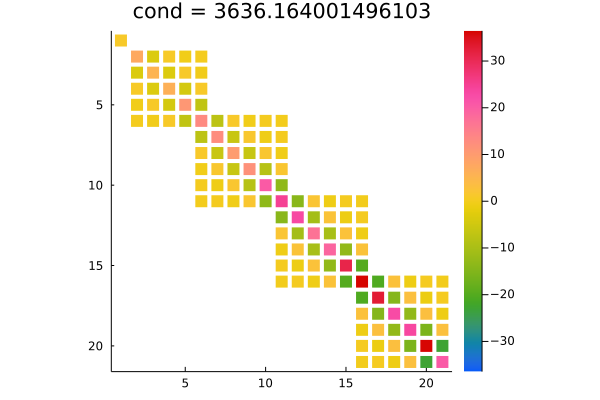

In [64]:
fe = FESpace(6, 6, 4)
u0 = zero(fe.xn)
J = fe_jacobian(u0, fe, dfq)
my_spy(J)
plot!(title="cond = $(cond(Matrix(J)))")]

* What is interesting about this matrix structure?
  * What would the matrix structure look like for a finite difference method that is 6th order accurate?

# Mass matrices

$$ v^T M u \sim \int v u $$

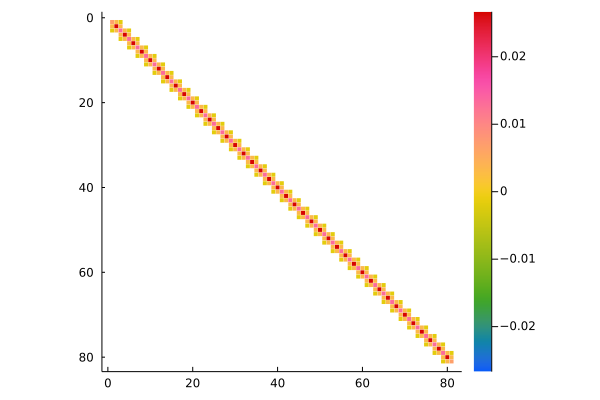

In [119]:
fe = FESpace(3, 3, 40)
u0 = zero(fe.xn)
function mass(q, u, du, Du, Ddu)
    df0 = du
    df1 = 0*du
    df0, df1
end
J = fe_jacobian(zero.(fe.xn), fe, mass, bci=[], bcv=[])
my_spy(J)

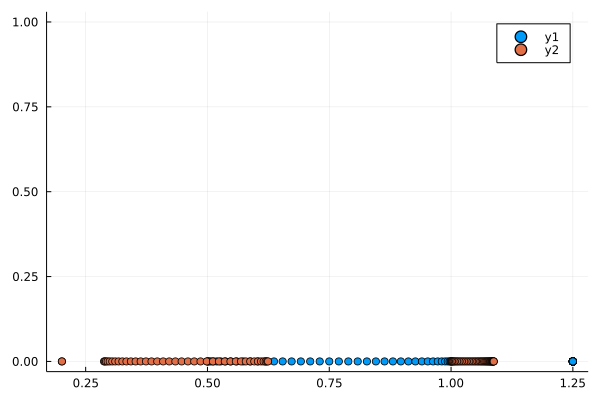

In [120]:
P = diagm(1 ./ diag(J))
e1 = eigvals(Matrix(P * J))
e2 = eigvals(Matrix(J) / maximum(J))
scatter([real.(e1) real.(e2)], [imag.(e1) imag.(e2)])

# Advection-diffusion (time independent)

\begin{align}
\mathbf w \cdot \nabla u - \nabla\cdot\big[ \kappa \nabla u \big] &= s & \int_\Omega v \mathbf w \cdot \nabla u + \int_\Omega \nabla v \cdot \kappa \nabla u  &= \int_\Omega v s, \forall v
\end{align}

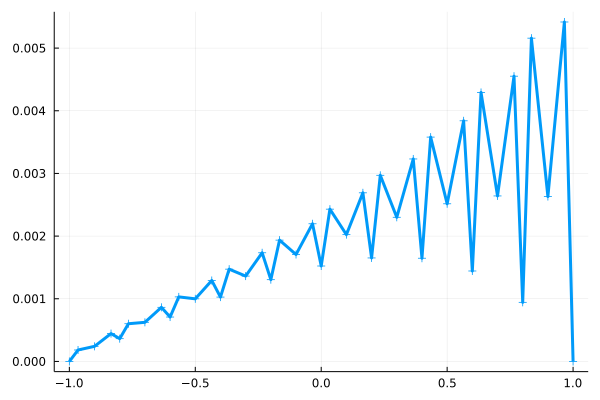

In [126]:
wind = 500
fq(q, u, Du) = wind .* Du -one.(u), 1 * Du

fe = FESpace(5, 5, 10)
u0 = zero(fe.xn)
N = length(fe.xn)
sol = nlsolve(u -> fe_residual(u, fe, fq; bci=[1, N], bcv=[0, 0]), zero(fe.xn), method=:newton)
plot(fe.xn, sol.zero, marker=:auto, legend=:none)

# Artificial diffusion and Streamline Upwinding

Observation: the residual is large where diffusion is needed.

$$\int_\Omega v \mathbf w \cdot \nabla u + \int_\Omega \nabla v \cdot \kappa \nabla u - \int_\Omega v s + \int_\Omega \tau^e (\mathbf w \cdot \nabla v) \big(\mathbf w \cdot \nabla u - \nabla\cdot(\kappa\nabla u) - s\big)$$

## Examine what this does to advection

$$(\mathbf w \cdot \nabla v)(\mathbf w \cdot \nabla u) = \nabla v (\mathbf w \otimes \mathbf w) \nabla u$$

This is "pencil" shaped diffusion, only along the streamline. If $\tau^e$ is chosen appropriately, this will be enough diffusion to get a Peclet number of about 1 when it needs it.

## Optimal stabilization
A nodally exact solution for 1D advection.
$$ \tau^e = \frac{h}{2 \lVert \mathbf w \rVert} \Big( \coth Pe - \frac{1}{Pe} \Big)$$

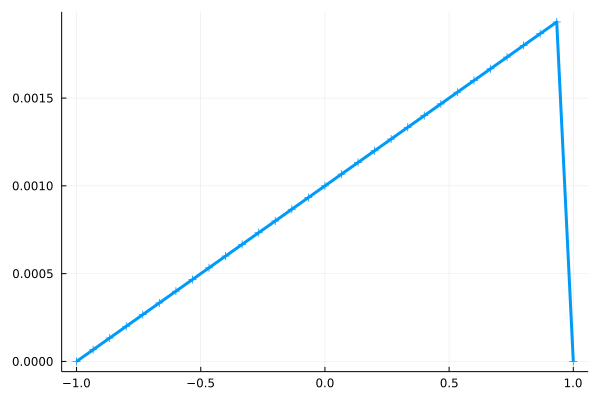

In [129]:
wind = 1000; k = 1
fq(q, u, Du) = wind .* Du -one.(u), k * Du + tau * wind.^2 .* Du

n = 30; h = 2 / n; Pe = abs(wind) * h / (2 * k)
tau = h / (2 * abs(wind)) * (coth(Pe) - 1 / Pe)
fe = FESpace(2, 2, n)
u0 = zero(fe.xn)
N = length(fe.xn)
sol = nlsolve(u -> fe_residual(u, fe, fq; bci=[1, N], bcv=[0, 0]), zero(fe.xn), method=:newton)
plot(fe.xn, sol.zero, marker=:auto, legend=:none)